In [1]:
import numpy as np
import os.path as osp
import os
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline 
import sys

src_path = os.path.abspath("../..")
if src_path not in sys.path:
    sys.path.append(src_path)
%load_ext autoreload
from dataset.nuscenes_dataset import nuScenesOdometryDataset, nuScenesDatasetConfig
from dataset.filters.filter_list import FilterList
from dataset.filters.kitti_gt_mo_filter import KittiGTMovingObjectFilter
from dataset.filters.range_filter import RangeFilter
from dataset.filters.apply_pose import ApplyPose

from hidden_points_removal import hidden_point_removal_o3d, hidden_point_removal_biasutti
from point_cloud_utils import transform_pcd, filter_points_from_dict, get_pcd, point_to_label, change_point_indices
from point_to_pixels import point_to_pixel
from visualization_utils import unite_pcd_and_img, color_pcd_with_labels, visualize_associations_in_img
from merge_pointclouds import build_associations, apply_associations_to_dict, merge_label_predictions, merge_pointclouds, build_associations_across_timesteps
from merged_sequences import merged_sequence

Here we define the dataset depending on kitti sequence!

In [2]:
DATASET_PATH = '/Users/laurenzheidrich/Downloads/nuScenes'
SEQUENCE_NUM = 1

config_filtered = nuScenesDatasetConfig(
    cache=True,
    dataset_path=DATASET_PATH,
    filters=FilterList(
        [
            KittiGTMovingObjectFilter(
                os.path.join(
                    DATASET_PATH,
                    "sequences",
                    "%.2d" % SEQUENCE_NUM,
                    "labels",
                )
            ),
            RangeFilter(2.5, 120),
            ApplyPose(),
        ]
    ),
)

dataset = nuScenesOdometryDataset(config_filtered, SEQUENCE_NUM)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.348 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


Now we read in the point cloud and the left and right image of the stereo camera. If labels for those images are available they can be read in, too!

In [3]:
points_index = 5
front_cam = "CAM_FRONT"
left_cam = "CAM_FRONT_LEFT"
right_cam = "CAM_FRONT_RIGHT"

pcd_o3d = get_pcd(dataset.get_point_cloud(points_index))
pcd = np.asarray(pcd_o3d.points)

front_image_PIL = dataset.get_image(front_cam, points_index)
front_image = cv2.cvtColor(np.array(front_image_PIL), cv2.COLOR_RGB2BGR)

left_image_PIL = dataset.get_image(left_cam, points_index)
left_image = cv2.cvtColor(np.array(left_image_PIL), cv2.COLOR_RGB2BGR)

right_image_PIL = dataset.get_image(right_cam, points_index)
right_image = cv2.cvtColor(np.array(right_image_PIL), cv2.COLOR_RGB2BGR)

# Only do this, if there is a SAM label present for respective point_index

front_label_PIL = dataset.get_sam_label(front_cam, points_index)
front_label = cv2.cvtColor(np.array(front_label_PIL), cv2.COLOR_RGB2BGR)

left_label_PIL = dataset.get_sam_label(left_cam, points_index)
left_label = cv2.cvtColor(np.array(left_label_PIL), cv2.COLOR_RGB2BGR)

right_label_PIL = dataset.get_sam_label(right_cam, points_index)
right_label = cv2.cvtColor(np.array(right_label_PIL), cv2.COLOR_RGB2BGR)

Now we read in the transformation matrixes and intriniscs for the two cameras and transform the point cloud accordingly!

In [4]:
T_lidar2leftcam, K_leftcam = dataset.get_calibration_matrices(left_cam)
T_lidar2frontcam, K_frontcam = dataset.get_calibration_matrices(front_cam)
T_lidar2rightcam, K_rightcam = dataset.get_calibration_matrices(right_cam)

pcd_leftcamframe = transform_pcd(pcd, T_lidar2leftcam)
pcd_frontcamframe = transform_pcd(pcd, T_lidar2frontcam)
pcd_rightcamframe = transform_pcd(pcd, T_lidar2rightcam)

Here we perform hidden point removal on the two camframes, since different points are hidden from different perspectives!

In [5]:
hpr_mode = "o3d" # "o3d" or "biscutti"

if hpr_mode == "o3d":
    #Camera set to [0,0,0] because we are already in camera frame and camera position is origin
    hpr_mask_leftcam = hidden_point_removal_o3d(pcd_leftcamframe, camera=[0,0,0], radius_factor=400) 
    hpr_mask_frontcam = hidden_point_removal_o3d(pcd_frontcamframe, camera=[0,0,0], radius_factor=400) 
    hpr_mask_rightcam = hidden_point_removal_o3d(pcd_rightcamframe, camera=[0,0,0], radius_factor=400) 
elif hpr_mode == "biasutti":
    hpr_mask_leftcam = hidden_point_removal_biasutti(pcd_leftcamframe, n_neighbours=64)
    hpr_mask_frontcam = hidden_point_removal_biasutti(pcd_frontcamframe, n_neighbours=64)
    hpr_mask_rightcam = hidden_point_removal_biasutti(pcd_rightcamframe, n_neighbours=64)

pcd_leftcamframe_hpr = pcd_leftcamframe[hpr_mask_leftcam]
pcd_frontcamframe_hpr = pcd_frontcamframe[hpr_mask_frontcam]
pcd_rightcamframe_hpr = pcd_rightcamframe[hpr_mask_rightcam]

Here we build up point-to-pixel correspondences from the pointclouds to the respective image frames!

In [6]:
point_to_pixel_dict_leftcam = point_to_pixel(pcd_leftcamframe, K_leftcam, left_image.shape[0], left_image.shape[1])
point_to_pixel_dict_frontcam = point_to_pixel(pcd_frontcamframe, K_frontcam, front_image.shape[0], front_image.shape[1])
point_to_pixel_dict_rightcam = point_to_pixel(pcd_rightcamframe, K_rightcam, right_image.shape[0], right_image.shape[1])

point_to_pixel_dict_hpr_leftcam = point_to_pixel(pcd_leftcamframe_hpr, K_leftcam, left_image.shape[0], left_image.shape[1])
point_to_pixel_dict_hpr_frontcam = point_to_pixel(pcd_frontcamframe_hpr, K_frontcam, front_image.shape[0], front_image.shape[1])
point_to_pixel_dict_hpr_rightcam = point_to_pixel(pcd_rightcamframe_hpr, K_rightcam, right_image.shape[0], right_image.shape[1])

In [7]:
print("Number of points in initial point cloud: ", pcd.shape[0])
print("Number of points after Hidden Point Removal from perspective of left camera: ", pcd_leftcamframe_hpr.shape[0])
print("Number of points after Hidden Point Removal from perspective of front camera: ", pcd_frontcamframe_hpr.shape[0])
print("Number of points after Hidden Point Removal from perspective of right camera: ", pcd_rightcamframe_hpr.shape[0])
print("Number of points projected on left image without Hidden Point Removal: ", len(point_to_pixel_dict_leftcam))
print("Number of points projected on front image without Hidden Point Removal: ", len(point_to_pixel_dict_frontcam))
print("Number of points projected on right image without Hidden Point Removal: ", len(point_to_pixel_dict_rightcam))
print("Number of points projected on left image with Hidden Point Removal: ", len(point_to_pixel_dict_hpr_leftcam))
print("Number of points projected on front image with Hidden Point Removal: ", len(point_to_pixel_dict_hpr_frontcam))
print("Number of points projected on right image with Hidden Point Removal: ", len(point_to_pixel_dict_hpr_rightcam))

Number of points in initial point cloud:  34720
Number of points after Hidden Point Removal from perspective of left camera:  26228
Number of points after Hidden Point Removal from perspective of front camera:  26017
Number of points after Hidden Point Removal from perspective of right camera:  25949
Number of points projected on left image without Hidden Point Removal:  3061
Number of points projected on front image without Hidden Point Removal:  2862
Number of points projected on right image without Hidden Point Removal:  2857
Number of points projected on left image with Hidden Point Removal:  2862
Number of points projected on front image with Hidden Point Removal:  2829
Number of points projected on right image with Hidden Point Removal:  2831


Here we unite the point clouds with the images and color the point clouds according to the available labels or the depth of the points onto the images!

In [8]:
# Coloring either with depth or label_map, depending on wether label is available
left_img_overlay = unite_pcd_and_img(point_to_pixel_dict_leftcam, left_image, left_label, coloring="label_map", radius=5)
front_img_overlay = unite_pcd_and_img(point_to_pixel_dict_frontcam, front_image, front_label, coloring="label_map", radius=5)
right_img_overlay = unite_pcd_and_img(point_to_pixel_dict_rightcam, right_image, right_label, coloring="label_map", radius=5)

left_img_overlay_hpr = unite_pcd_and_img(point_to_pixel_dict_hpr_leftcam, left_image, left_label, coloring="label_map", radius=5)
front_img_overlay_hpr = unite_pcd_and_img(point_to_pixel_dict_hpr_frontcam, front_image, front_label, coloring="label_map", radius=5)
right_img_overlay_hpr = unite_pcd_and_img(point_to_pixel_dict_hpr_rightcam, right_image, right_label, coloring="label_map", radius=5)

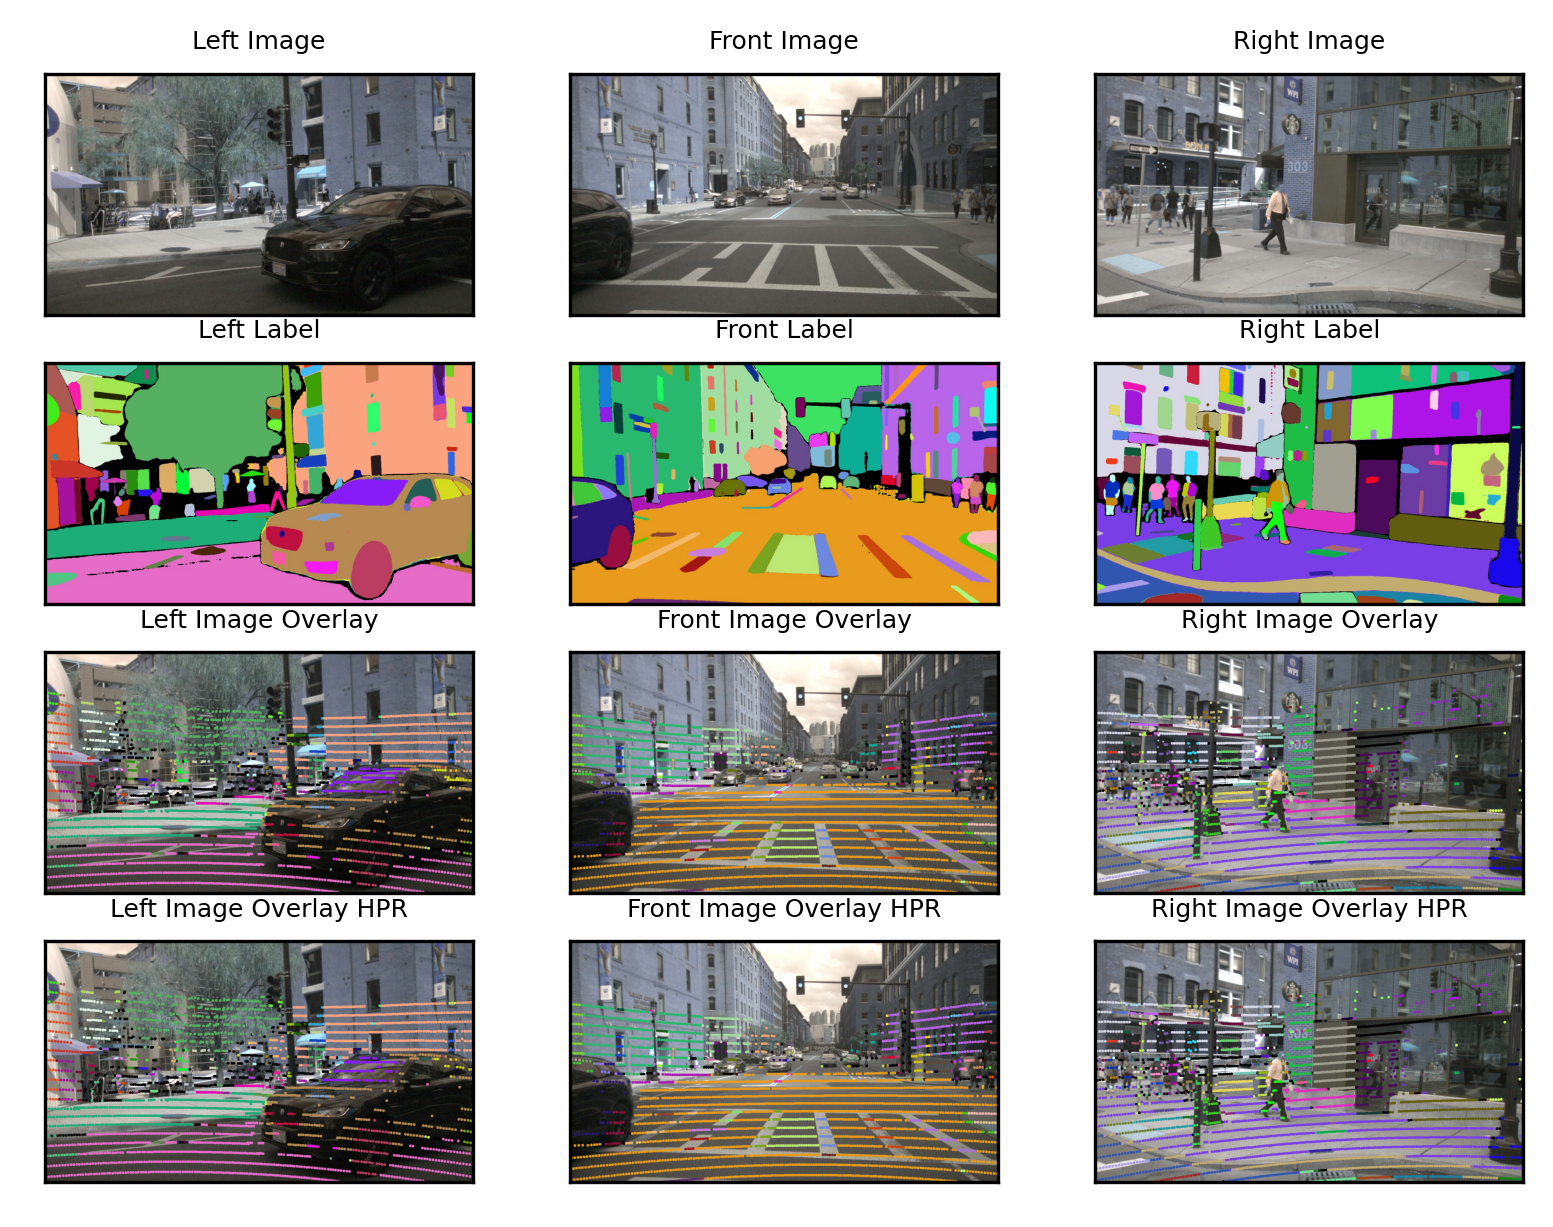

In [9]:
fig, axes = plt.subplots(4, 3)

images = [left_image, front_image, right_image, left_label, front_label, right_label, left_img_overlay, front_img_overlay, right_img_overlay, left_img_overlay_hpr, front_img_overlay_hpr, right_img_overlay_hpr]

titles = ["Left Image", "Front Image", "Right Image", "Left Label", "Front Label", "Right Label", "Left Image Overlay", "Front Image Overlay", "Right Image Overlay", "Left Image Overlay HPR", "Front Image Overlay HPR", "Right Image Overlay HPR"]

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(titles[i], fontsize=6)
    ax.set_xticks([]), ax.set_yticks([])

fig.set_dpi(300)

plt.show()

Here we filter the point clouds according to the points that are visible within the image frames!

In [10]:
pcd_leftcamframe_fov = filter_points_from_dict(pcd, point_to_pixel_dict_leftcam)
pcd_frontcamframe_fov = filter_points_from_dict(pcd, point_to_pixel_dict_frontcam)
pcd_rightcamframe_fov = filter_points_from_dict(pcd, point_to_pixel_dict_rightcam)

pcd_leftcamframe_fov_hpr = filter_points_from_dict(pcd_leftcamframe_hpr, point_to_pixel_dict_hpr_leftcam)
pcd_frontcamframe_fov_hpr = filter_points_from_dict(pcd_frontcamframe_hpr, point_to_pixel_dict_hpr_frontcam)
pcd_rightcamframe_fov_hpr = filter_points_from_dict(pcd_rightcamframe_hpr, point_to_pixel_dict_hpr_rightcam)

For each of those points, we build up correspondences that map the point index to label color!

In [11]:
point_to_label_dict_leftcam = point_to_label(point_to_pixel_dict_leftcam, left_label)
point_to_label_dict_frontcam = point_to_label(point_to_pixel_dict_frontcam, front_label)
point_to_label_dict_rightcam = point_to_label(point_to_pixel_dict_rightcam, right_label)

point_to_label_dict_hpr_leftcam = point_to_label(point_to_pixel_dict_hpr_leftcam, left_label)
point_to_label_dict_hpr_frontcam = point_to_label(point_to_pixel_dict_hpr_frontcam, front_label)
point_to_label_dict_hpr_rightcam = point_to_label(point_to_pixel_dict_hpr_rightcam, right_label)

Using those correspondences, we can now color the point clouds with the colors from the labels!

In [12]:
pcd_leftcamframe_fov = color_pcd_with_labels(pcd_leftcamframe_fov, point_to_label_dict_leftcam)
pcd_frontcamframe_fov = color_pcd_with_labels(pcd_frontcamframe_fov, point_to_label_dict_frontcam)
pcd_rightcamframe_fov = color_pcd_with_labels(pcd_rightcamframe_fov, point_to_label_dict_rightcam)

pcd_leftcamframe_fov_hpr = color_pcd_with_labels(pcd_leftcamframe_fov_hpr, point_to_label_dict_hpr_leftcam)
pcd_frontcamframe_fov_hpr = color_pcd_with_labels(pcd_frontcamframe_fov_hpr, point_to_label_dict_hpr_frontcam)
pcd_rightcamframe_fov_hpr = color_pcd_with_labels(pcd_rightcamframe_fov_hpr, point_to_label_dict_hpr_rightcam)

In [14]:
o3d.io.write_point_cloud("filtered.pcd", pcd_rightcamframe_fov)

True